In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
import torch
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    train_validate_split
)

---

## Getting the data

In [3]:
camels_config = CamelsCHConfig(
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
    timeseries_pattern="CAMELS_CH_obs_based_*.csv",
    static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
    use_climate=False,
    use_geology=False,
    use_glacier=False,
    use_human_influence=False,
    use_hydrogeology=False,
    use_hydrology=False,
    use_landcover=False,
    use_soil=False,
    use_topographic=False,
)

camels = CamelsCH(camels_config)
camels.load_stations(["2018", "2019", "2020"])

Loaded time series data for 3 stations


In [4]:
# static = camels.get_static_attributes()
# # q_mean	runoff_ratio	stream_elas	slope_fdc	baseflow_index_landson	hfd_mean
# static = static[["gauge_id", "q_mean", "runoff_ratio", "stream_elas", "slope_fdc", "baseflow_index_landson", "hfd_mean"]]
# static

## Preprocessing

In [5]:
data = camels.get_time_series()
data = data[
    [
        "gauge_id",
        "date",
        "discharge_spec(mm/d)",
        "precipitation(mm/d)",
        "temperature_mean(degC)",
    ]
]

# Split into train/test
df_train, df_test = train_validate_split(data, train_ratio=0.8)

# Scale by basin
scaled_train, scaled_test, params = scale_time_series(
    df_train,
    df_test,
    features=["discharge_spec(mm/d)", "precipitation(mm/d)", "temperature_mean(degC)"],
    by_basin=True,  # Set False for global scaling
)

In [6]:
# attributes = [col for col in static.columns if col != 'gauge_id']

# # Scale the attributes
# scaled_static_df, scaling_params = scale_static_attributes(static, attributes)

# # Add back gauge_id if needed
# scaled_static_df['gauge_id'] = static['gauge_id']

# # Inverse scale to verify
# original_df = inverse_scale_static_attributes(scaled_static_df[attributes], scaling_params)
# original_df['gauge_id'] = static['gauge_id']

# # Print results
# print("\nOriginal values:")
# print(static)
# print("\nScaled values:")
# print(scaled_static_df)
# print("\nInverse scaled values:")
# print(original_df)

# # Verify the scaling worked correctly
# np.testing.assert_array_almost_equal(
#     static[attributes].values,
#     original_df[attributes].values
# )
# print("\nVerification passed: Original and inverse-scaled values match!")

## Wrap the data in a PyTorch dataset

In [7]:
features = ["discharge_spec(mm/d)", "precipitation(mm/d)", "temperature_mean(degC)"]
target = "discharge_spec(mm/d)"

# Create dataset
train_dataset = HydroDataset(
    time_series_df=scaled_train,
    static_df=None,
    input_length=30,
    output_length=5,
    features=features,
    target=target,
)

validate_dataset = HydroDataset(
    time_series_df=scaled_train,
    static_df=None,
    input_length=30,
    output_length=5,
    features=features,
    target=target,
)

Created 34962 valid sequences.
Created 34962 valid sequences.


## Make the dataset iterable by creating a DataLoader

In [8]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

## Train the simple LSTM model

In [9]:
from src.models.lstm import SimpleLSTM
from torch.optim import Adam
from torch.nn import MSELoss

In [10]:
model = SimpleLSTM(
    input_size=len(features),  # 3 features
    hidden_size=64,
    num_layers=1,
    output_size=5  # 5 prediction steps
)

criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        X, y = batch['X'], batch['y']
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')

Epoch 1, Loss: 0.2904
Epoch 2, Loss: 0.2520
Epoch 3, Loss: 0.2464
Epoch 4, Loss: 0.2398
Epoch 5, Loss: 0.2305
Epoch 6, Loss: 0.2249
Epoch 7, Loss: 0.2206
Epoch 8, Loss: 0.2170
Epoch 9, Loss: 0.2132
Epoch 10, Loss: 0.2104


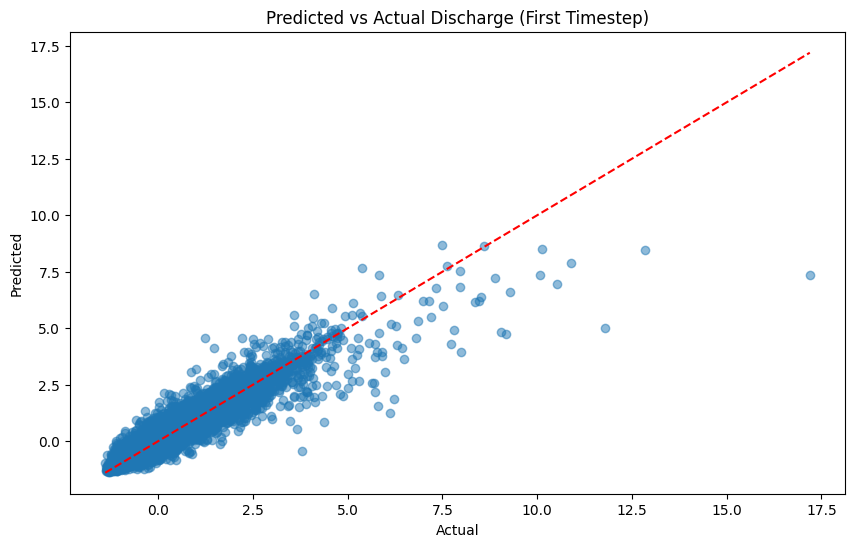

MSE: 0.2054
MAE: 0.2525


In [11]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in validate_loader:
        X, y = batch["X"], batch["y"]
        pred = model(X)
        all_preds.append(pred.numpy())
        all_targets.append(y.numpy())

predictions = np.concatenate(all_preds, axis=0)
targets = np.concatenate(all_targets, axis=0)

# Plot predicted vs actual for first timestep
plt.figure(figsize=(10, 6))
plt.scatter(targets[:, 0], predictions[:, 0], alpha=0.5)
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Discharge (First Timestep)")
plt.show()

# Calculate metrics
mse = np.mean((predictions - targets) ** 2)
mae = np.mean(np.abs(predictions - targets))
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

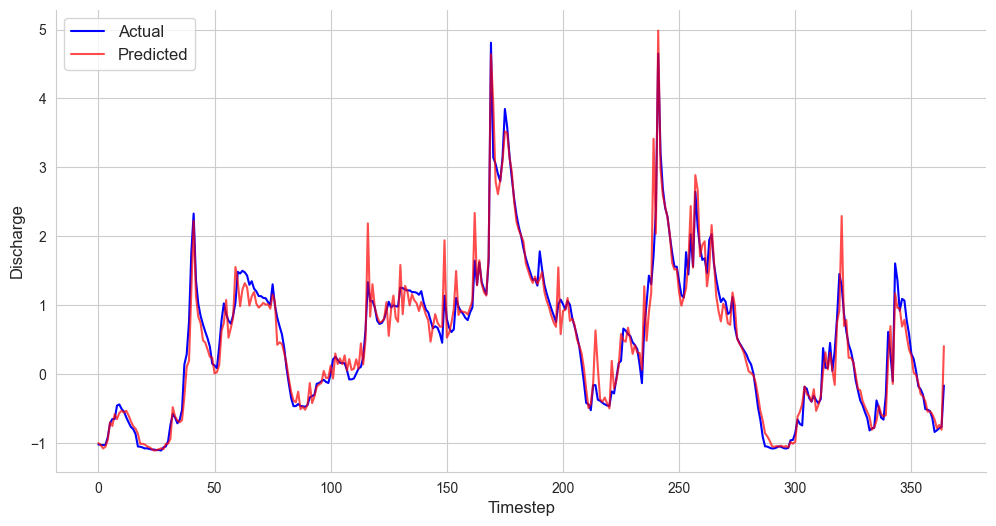

In [20]:
import seaborn as sns

# Plot the first 365 points
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(365), y=targets[:365, 0], label="Actual", color="blue")
sns.lineplot(x=range(365), y=predictions[:365, 0], label="Predicted", color="red", alpha=0.7)

# Labels and title
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Discharge", fontsize=12)
# plt.title("Time Series of Predicted vs Actual Discharge (First 365 Points)", fontsize=14, fontweight="bold")

# Improve legend
plt.legend(fontsize=12, loc="upper left", frameon=True)

sns.despine()

# Show plot
plt.show()